In [4]:
import numpy as np

class MinesweeperEnv:
    """
    Grid: (r x c) with m mines.
    Observation: (H, W, 9) one-hot of VISIBLE counts 0..8; covered cells are all zeros.
    Actions: flat index [0..H*W-1] = click cell (i,j). Invalid to click already revealed.
    Rewards: +0.1 safe, +1 win, -1 lose. No extra reward for flood size.
    """
    def __init__(self, rows=9, cols=9, mines=10, seed=None):
        self.r, self.c, self.m = rows, cols, mines
        self.rng = np.random.default_rng(seed)
        self.board = np.zeros((rows, cols), dtype=np.int8)   # -1 = mine, 0 = empty
        self.mask  = np.ones((rows, cols), dtype=np.int8)    # 1 = covered, 0 = revealed
        self._generated = False
        self.score = 0
        self.explosion = False

    # ---------- helpers ----------
    def _idx(self, a): return divmod(a, self.c)
    def _flat(self, i, j): return i*self.c + j

    def _neighbors(self, i, j):
        for di, dj in ((1,0),(0,1),(1,1),(-1,0),(0,-1),(-1,-1),(1,-1),(-1,1)):
            x, y = i+di, j+dj
            if 0 <= x < self.r and 0 <= y < self.c:
                yield x, y

    def _neighbor_counts(self):
        mines = (self.board == -1).astype(np.int8)
        p = np.pad(mines, 1)
        return (
            p[0:-2,0:-2] + p[0:-2,1:-1] + p[0:-2,2:] +
            p[1:-1,0:-2]                + p[1:-1,2:] +
            p[2:  ,0:-2] + p[2:  ,1:-1] + p[2:  ,2:]
        )

    def _place_mines_after_first_click(self, safe_i, safe_j):
        n = self.r * self.c
        exclude = {safe_i*self.c + safe_j}
        assert self.m < n - 1
        candidates = np.fromiter((k for k in range(n) if k not in exclude), dtype=np.int32)
        mine_idx = self.rng.choice(candidates, self.m, replace=False)
        self.board[:] = 0
        self.board.flat[mine_idx] = -1
        self._generated = True

    def _flood_reveal(self, i, j):
        stack = [(i, j)]
        while stack:
            x, y = stack.pop()
            if self.mask[x, y] == 0 or self.board[x, y] == -1:
                continue
            self.mask[x, y] = 0  # reveal current
            if self._counts[x, y] == 0:
                # reveal all neighbors; push only zeros
                for nx, ny in self._neighbors(x, y):
                    if self.mask[nx, ny] == 1 and self.board[nx, ny] != -1:
                        self.mask[nx, ny] = 0
                        if self._counts[nx, ny] == 0:
                            stack.append((nx, ny))


    # ---------- gym-like API ----------
    @property
    def action_space_n(self):  # number of actions
        return self.r * self.c

    def legal_action_mask(self):
        """True for legal (covered) cells; False for revealed cells."""
        return (self.mask == 1).reshape(-1)

    def _make_obs(self):
        """
        Return (H, W, 9) one-hot of VISIBLE counts 0..8.
        Covered cells contribute zeros across all 9 channels.
        """
        covered = (self.mask == 1)
        revealed = ~covered
        planes = []
        for k in range(9):  # 0..8
            planes.append(((self._counts == k) & revealed).astype(np.float32))
        obs = np.stack(planes, axis=-1)      # (H,W,9)
        return obs

    def reset(self):
        self.board.fill(0)
        self.mask.fill(1)
        self._generated = False
        self.score = 0
        self.explosion = False
        self._counts = np.zeros_like(self.board, dtype=np.int8)
        return self._make_obs()

    def step(self, action):
        """
        action: flat index 0..(H*W-1)
        returns: next_obs, reward, done, info
        """
        i, j = self._idx(action)

        if not self._generated:
            self._place_mines_after_first_click(i, j)
            self._counts = self._neighbor_counts()

        if self.mask[i, j] == 0:
            return self._make_obs(), -0.05, False, {"illegal": True}

        if self.board[i, j] == -1:
            self.mask[i, j] = 0
            self.explosion = True
            return self._make_obs(), -1.0, True, {"result": "lose"}

        self._flood_reveal(i, j)
        self.score = int((self.mask == 0).sum())

        if np.all(self.mask[self.board != -1] == 0):
            return self._make_obs(), +1.0, True, {"result": "win"}

        return self._make_obs(), +0.1, False, {} 


In [12]:
# ====================================================================================================
# Model/TF utilities and helpers. Only substantive change: the model builder is now a class method
# on NeuralNetwork so any drop-in NN can keep the same class name + interface.

import os
import numpy as np
import tensorflow as tf

# ----- Precision / XLA -----
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)  

# ----- Simple loss logs -----
class LossLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"[epoch {epoch+1}] loss={logs.get('loss'):.6f}")
loss_logger = LossLogger()
csv_logger  = tf.keras.callbacks.CSVLogger('train_log.csv', append=False)

def d4_map(x, y, w):
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k)
    y = tf.image.rot90(y, k)
    w = tf.image.rot90(w, k)
    do_flip = tf.random.uniform([], 0, 1) < 0.5
    x = tf.cond(do_flip, lambda: tf.image.flip_left_right(x), lambda: x)
    y = tf.cond(do_flip, lambda: tf.image.flip_left_right(y), lambda: y)
    w = tf.cond(do_flip, lambda: tf.image.flip_left_right(w), lambda: w)
    return x, y, w
    
# ---------------------- Env helper ----------------------
def board_from_seed(env, seed, first_click=None):
    env.rng = np.random.default_rng(seed)
    _ = env.reset()
    if first_click is None:
        first_click = (env.r // 2, env.c // 2)
    a = first_click[0] * env.c + first_click[1]
    s, r, done, info = env.step(a)
    return s

# ---------- vectorized 8-neighbor sum + frontier ----------
def _nb_sum_uint8(mat_bool: np.ndarray) -> np.ndarray:
    p = np.pad(mat_bool.astype(np.uint8), 1, mode="constant")
    s = (
        p[0:-2, 0:-2] + p[0:-2, 1:-1] + p[0:-2, 2:] +
        p[1:-1, 0:-2] +                     p[1:-1, 2:] +
        p[2:  , 0:-2] + p[2:  , 1:-1] + p[2:  , 2:]
    )
    return s

def _frontier_mask_fast(covered: np.ndarray, revealed: np.ndarray) -> np.ndarray:
    return covered & (_nb_sum_uint8(revealed) > 0)

# ---------------------- Dataset builder ----------------------
def collect_safety_dataset(env, seeds, states_per_board=10, random_safe_steps=3):
    H, W = env.r, env.c
    C = 9
    total = len(seeds) * states_per_board
    X = np.empty((total, H, W, C), dtype=np.float32)
    Y = np.empty((total, H, W, 1), dtype=np.float32)
    M = np.empty((total, H, W, 1), dtype=np.float32)

    rng = np.random.default_rng(0)
    write_i = 0
    for sd in seeds:
        _ = board_from_seed(env, sd)
        for _k in range(states_per_board):
            obs = env._make_obs().astype(np.float32)

            covered  = (env.mask == 1)
            revealed = ~covered
            frontier = _frontier_mask_fast(covered, revealed)

            y = ((env.board != -1) & frontier).astype(np.float32)[..., None]
            m = frontier.astype(np.float32)[..., None]

            X[write_i] = obs
            Y[write_i] = y
            M[write_i] = m
            write_i += 1

            for _step in range(random_safe_steps):
                safe_mask = (env.mask == 1) & (env.board != -1)
                if not safe_mask.any():
                    break
                safe_flat = np.flatnonzero(safe_mask.ravel())
                a = int(safe_flat[rng.integers(len(safe_flat))])
                i, j = divmod(a, env.c)
                env.step(i * env.c + j)
        _ = board_from_seed(env, sd)
    return X, Y, M

# -------------------- Neural Network --------------------
# class NeuralNetwork:
#     """
#     Drop-in NN wrapper.
#     """
#     def __init__(self, input_channels: int = 9):
#         self.c = input_channels
#         self.model = None

#     def build(self, h=None, w=None):
#         """Build a fully-convolutional model that supports variable HxW."""
#         self.model = self._build_safety_model_fast(h, w, c=self.c)
#         return self.model

#     @staticmethod
#     def _build_safety_model_fast(h, w, c=9):
#         """
#         Depthwise-separable U-Net that avoids tf.image.resize (XLA-safe).
#         UpSampling2D + pad/crop alignment wrapped in a Lambda.

#         NOTE: To allow training across multiple board sizes, (h, w) can be None.
#         """
#         import tensorflow as tf
#         from tensorflow.keras import layers

#         def ds_block(x, f):
#             x = layers.SeparableConv2D(f, 3, padding="same", use_bias=False)(x)
#             x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
#             x = layers.SeparableConv2D(f, 3, padding="same", use_bias=False)(x)
#             x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
#             return x

#         def down(x, f):
        #     x = ds_block(x, f); skip = x
        #     x = layers.MaxPooling2D(2, padding="same")(x)  # ceil-div; may yield 1px mismatch
        #     return x, skip

        # def align_to_layer():
        #     def fn(inputs):
        #         x, ref = inputs
        #         x_shape = tf.shape(x); r_shape = tf.shape(ref)
        #         xh, xw = x_shape[1], x_shape[2]
        #         rh, rw = r_shape[1], r_shape[2]
        #         dh = rh - xh; dw = rw - xw
        #         pad_top    = tf.maximum(0, dh // 2)
        #         pad_bottom = tf.maximum(0, dh - pad_top)
        #         pad_left   = tf.maximum(0, dw // 2)
        #         pad_right  = tf.maximum(0, dw - pad_left)
        #         paddings = tf.stack([[0,0],[pad_top,pad_bottom],[pad_left,pad_right],[0,0]])
        #         x = tf.pad(x, paddings)
        #         x = x[:, :rh, :rw, :]
        #         return x
        #     return tf.keras.layers.Lambda(fn)

        # def up(x, skip, f):
        #     x = tf.keras.layers.UpSampling2D(2, interpolation="nearest")(x)
        #     x = align_to_layer()([x, skip])
        #     x = tf.keras.layers.Concatenate()([x, skip])
        #     x = ds_block(x, f)
        #     return x

        # # Allow variable spatial dims for multi-size training
        # inp = tf.keras.Input(shape=(h if h is not None else None,
        #                             w if w is not None else None, c))
        # x, s1 = down(inp, 32)
        # x, s2 = down(x, 64)
        # x = ds_block(x, 128)
        # x = up(x, s2, 64)
        # x = up(x, s1, 32)
        # out = tf.keras.layers.Conv2D(1, 1, padding="same", activation=None)(x)
        # return tf.keras.Model(inp, out)

In [13]:
# ===== TensorFlow/Keras GNN backend: drop-in alternative matching your API =====
import tensorflow as tf
from tensorflow.keras import layers, models

class NeuralNetwork:
    """
    Grid-GNN in Keras.
    - Fully convolutional; supports variable H×W.
    - Residual message passing using DepthwiseConv2D(3x3) + Conv2D(1x1).
    """
    def __init__(self, input_channels: int = 9, hidden: int = 64, depth: int = 5):
        self.c = input_channels
        self.hidden = hidden
        self.depth = depth
        self.model = None

    def build(self, h=None, w=None):
        """
        Build a variable-size (None,None) NHWC model that outputs per-cell logits (H,W,1).
        You can pass fixed h,w if you like; leaving them None is best for multi-size training.
        """
        inp = layers.Input(shape=(h if h is not None else None,
                                  w if w is not None else None,
                                  self.c))  # NHWC

        x = layers.Conv2D(self.hidden, 1, use_bias=False)(inp)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        h = x
        for _ in range(self.depth):
            y = layers.DepthwiseConv2D(3, padding="same", use_bias=False)(h)
            y = layers.BatchNormalization()(y)
            y = layers.ReLU()(y)
            y = layers.Conv2D(self.hidden, 1, use_bias=False)(y)
            y = layers.BatchNormalization()(y)
            y = layers.ReLU()(y)
            h = layers.Add()([h, y])  # residual

        # Per-cell logit
        out = layers.Conv2D(1, 1, padding="same", activation=None)(h)
        self.model = models.Model(inp, out)
        return self.model

class WeightedBCEFromLogits(tf.keras.losses.Loss):
    def __init__(self, pos_weight=3.0):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE)
        self.pos_weight = tf.cast(pos_weight, tf.float32)
    def call(self, y_true, y_pred):
        return tf.nn.weighted_cross_entropy_with_logits(
            labels=tf.cast(y_true, tf.float32),
            logits=tf.cast(y_pred, tf.float32),
            pos_weight=self.pos_weight
        )

def compile_for_speed_keras(model, pos_weight=3.0, lr=3e-4, use_xla=True):
    loss = WeightedBCEFromLogits(pos_weight)
    opt = tf.keras.optimizers.Adam(lr)
    model.compile(
        optimizer=opt,
        loss=loss,
        jit_compile=bool(use_xla),
        steps_per_execution=128,
        run_eagerly=False,
    )
    return model

def train_safety_keras_gnn(env, seeds, model, *,
                           epochs=35, batch=128, states_per_board=6, steps_per_state=4,
                           pos_weight=3.0, lr=3e-4, use_xla=True,
                           loss_logger=None, csv_logger=None):
    # Reuse your dataset builder & tf.data pipeline
    X, Y, W = collect_safety_dataset(env, seeds, states_per_board, steps_per_state)
    X = X.astype("float16"); Y = Y.astype("float16"); W = W.astype("float16")
    ds = make_dataset(X, Y, W, batch=batch, shuffle=True)
    model = compile_for_speed_keras(model, pos_weight=pos_weight, lr=lr, use_xla=use_xla)
    callbacks = []
    if loss_logger is not None: callbacks.append(loss_logger)
    if csv_logger  is not None: callbacks.append(csv_logger)
    model.fit(ds, epochs=epochs, verbose=1, callbacks=callbacks)
    return model

# Minimal TTA wrappers (works if you haven't already defined the shared ones)
@tf.function(jit_compile=True)
def _predict_no_tta_keras(model, X):
    logits = model(X, training=False)
    return tf.math.sigmoid(logits)

@tf.function(jit_compile=True)
def _predict_tta4_keras(model, X):
    outs = []
    for k in range(4):
        xk = tf.image.rot90(X, k)
        yk = model(xk, training=False)
        yk = tf.image.rot90(yk, 4 - k)
        outs.append(yk)
    logits = tf.add_n(outs) / 4.0
    return tf.math.sigmoid(logits)

def _predict_with_tta_keras(model, s_np, tta=0):
    X = tf.convert_to_tensor(s_np, dtype=tf.float32)
    if tta == 0:   p = _predict_no_tta_keras(model, X)
    elif tta == 4: p = _predict_tta4_keras(model, X)
    else:          p = _predict_tta4_keras(model, X)  # simple fallback
    return p


In [14]:
def make_dataset(X, Y, W, batch=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, Y, W))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(X), 10000), reshuffle_each_iteration=True)
    ds = ds.map(d4_map, num_parallel_calls=tf.data.AUTOTUNE)
    # Keras will consume (x, y, sample_weight) if we return 3-tuple
    ds = ds.batch(batch, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    return ds
        
loss_logger = LossLogger()
csv_logger = tf.keras.callbacks.CSVLogger('train_log.csv', append=False)

# Build the GNN
nn = NeuralNetwork(input_channels=9, hidden=64, depth=5)
model = nn.build(h=None, w=None)
train_schedules = [(10,10,[10,15,20,25])]
for (rows, cols, mine_list) in train_schedules:
    for mines in mine_list:
        env = MinesweeperEnv(rows=rows, cols=cols, mines=mines, seed=0)
        train_safety_keras_gnn(env, list(range(0,25000)), model,
                               epochs=10, batch=128,
                               states_per_board=7, steps_per_state=6,
                               pos_weight=3.0, lr=1e-3, use_xla=True,
                               loss_logger=loss_logger, csv_logger=csv_logger)


Epoch 1/10


I0000 00:00:1763097937.453815     110 service.cc:148] XLA service 0x7ad7e4004be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763097937.454585     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763097937.454605     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763097937.487795     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763097937.595101     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1281/1368 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1309[epoch 1] loss=0.100120
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.1290
Epoch 2/10
 769/1368 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0655

KeyboardInterrupt: 

In [16]:
def eval_greedy_on_seeds_keras_gnn(env, model, seeds, max_moves=None, tta=0, verbose=False):
    import numpy as np
    wins = 0; H, W = env.r, env.c
    for sd in seeds:
        _ = board_from_seed(env, sd); done = False; moves = 0
        while not done:
            s = env._make_obs()[None, ...].astype("float32")
            p_tf = _predict_with_tta_keras(model, s, tta=tta)   # tf.Tensor
            p = p_tf[0, ..., 0].numpy()                         # (H,W) numpy (likely float16)
            covered  = (env.mask == 1); revealed = ~covered
            frontier = _frontier_mask_fast(covered, revealed)
            cand = frontier & covered                           # (H,W) bool
            if not cand.any(): 
                cand = covered
            # Use NumPy for masking to avoid TF dtype issues under mixed precision
            scores = np.where(cand, p, -1e9)                    # (H,W) numpy
            i, j = np.unravel_index(np.argmax(scores), scores.shape)
            _, _, done, info = env.step(i * W + j); moves += 1
            if max_moves and moves >= max_moves: break
        if verbose: print(info.get("result"))
        wins += 1 if info.get("result") == "win" else 0
    return wins / len(seeds)

rang = np.arange(20, 60)   # integers 1..30
winrates = []

for m in rang:
    env = MinesweeperEnv(rows=16, cols=16, mines=m, seed=123)
    wr_gnn = eval_greedy_on_seeds_keras_gnn(env, model, list(range(20000,20100)), tta=0)
    winrates.append(wr_gnn)
    print(f"16x16, mines={m}: winrate={wr_gnn:.3f}")



16x16, mines=20: winrate=0.920


KeyboardInterrupt: 

$\text{Figure Generation}$

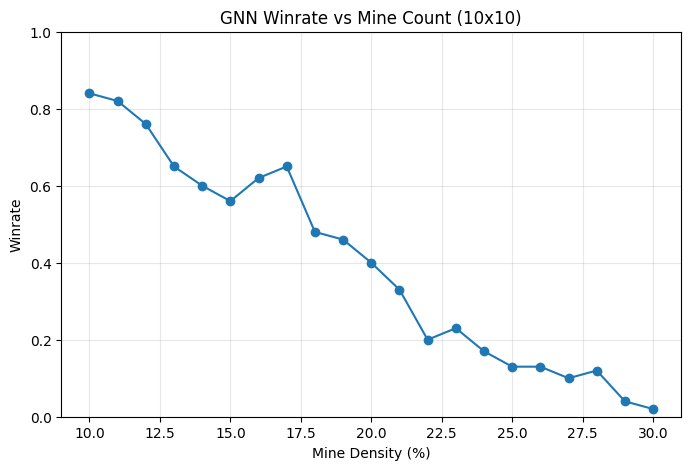

In [21]:
import matplotlib.pyplot as plt
# --- Nice plot ---
plt.figure(figsize=(8,5))
plt.plot(rang, winrates, marker='o')
plt.title("GNN Winrate vs Mine Count (10x10)")
plt.xlabel("Mine Density (%)")
plt.ylabel("Winrate")
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.show()


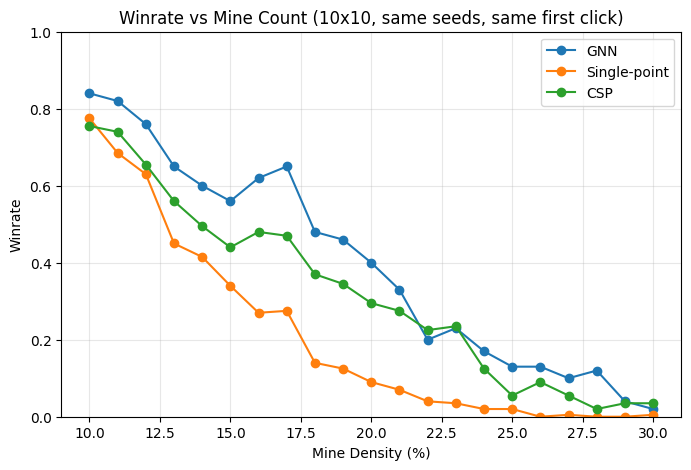

In [23]:
# --- Baselines for MinesweeperEnv: Single-Point and CSP, evaluated on same seeds ---
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# ---------- Utility: deterministic first move so boards match across solvers ----------
def first_click_index(env):
    i, j = env.r // 2, env.c // 2  # fixed center click
    return env._flat(i, j)

def neighbors(env, i, j):
    for x, y in env._neighbors(i, j):
        yield x, y

def covered_neighbors(env, i, j):
    return [(x, y) for x, y in neighbors(env, i, j) if env.mask[x, y] == 1 and env.board[x, y] != -1]

def revealed_number(env, i, j):
    # Only valid if revealed
    return int(env._counts[i, j])

def frontier_cells(env):
    cov = (env.mask == 1)
    rev = ~cov
    F = set()
    for i in range(env.r):
        for j in range(env.c):
            if rev[i, j] and env._counts[i, j] > 0:
                for x, y in neighbors(env, i, j):
                    if env.mask[x, y] == 1:
                        F.add((x, y))
    return F

# ---------- Single-Point solver (local deterministic rules + random guess) ----------
def solve_single_point(env, rng):
    env.reset()
    # same first click for all solvers
    obs, r, done, info = env.step(first_click_index(env))
    flags = set()
    while not done:
        progress = False

        # Collect simple deductions
        to_flag = set()
        to_click = set()

        # Scan all revealed numbered cells
        for i in range(env.r):
            for j in range(env.c):
                if env.mask[i, j] == 0 and env._counts[i, j] > 0:
                    cov = [(x, y) for x, y in neighbors(env, i, j) if env.mask[x, y] == 1 and (x, y) not in flags]
                    f_cnt = sum((x, y) in flags for x, y in neighbors(env, i, j))
                    need = env._counts[i, j] - f_cnt
                    if need < 0:  # inconsistent flags; ignore
                        continue
                    if need == 0 and cov:
                        # all covered neighbors are safe
                        to_click.update(cov)
                    elif need == len(cov) and len(cov) > 0:
                        # all covered neighbors are mines
                        to_flag.update(cov)

        if to_flag:
            flags.update(to_flag)
            progress = True

        if to_click:
            # Click all deduced safe cells
            # Stop early if any click ends the game
            for (x, y) in list(to_click):
                if env.mask[x, y] == 1:
                    obs, r, done, info = env.step(env._flat(x, y))
                    if done:
                        break
            progress = True
            if done:
                break

        if not progress:
            # Guess uniformly among covered non-flagged frontier; fallback to any covered
            F = [xy for xy in frontier_cells(env) if xy not in flags]
            if not F:
                F = [(i, j) for i in range(env.r) for j in range(env.c) if env.mask[i, j] == 1 and (i, j) not in flags]
            if not F:
                # No legal moves; should not happen unless inconsistent
                break
            x, y = F[rng.integers(len(F))]
            obs, r, done, info = env.step(env._flat(x, y))

    return info.get("result") == "win"

# ---------- CSP solver (exact inference on frontier components; guess by min P(mine)) ----------
def build_constraints(env, vars_set):
    """Return constraints over vars (indexed 0..V-1) for all numbered border cells."""
    idx = {xy: k for k, xy in enumerate(vars_set)}
    constraints = []  # list of (list(var_idx), sum_needed)
    for i in range(env.r):
        for j in range(env.c):
            if env.mask[i, j] == 0 and env._counts[i, j] > 0:
                neigh_cov = [(x, y) for x, y in neighbors(env, i, j) if env.mask[x, y] == 1]
                var_idx = [idx[xy] for xy in neigh_cov if xy in idx]
                if not var_idx:
                    continue
                need = env._counts[i, j]
                # Subtract already-flagged if you maintain flags; here we do not place flags persistently
                constraints.append((var_idx, need))
    return constraints

def componentize(env, F):
    """Split frontier into connected components via shared numbered neighbors."""
    # Build adjacency among frontier cells: two frontier cells connect if they appear in a common constraint
    F_list = list(F)
    idx = {xy: k for k, xy in enumerate(F_list)}
    adj = [set() for _ in F_list]
    # Build constraints via numbered cells
    for i in range(env.r):
        for j in range(env.c):
            if env.mask[i, j] == 0 and env._counts[i, j] > 0:
                comp = [(x, y) for x, y in neighbors(env, i, j) if env.mask[x, y] == 1 and (x, y) in idx]
                for a in comp:
                    for b in comp:
                        if a != b:
                            adj[idx[a]].add(idx[b])
    # BFS components
    comps = []
    seen = set()
    for k in range(len(F_list)):
        if k in seen:
            continue
        q = deque([k]); seen.add(k); cur = [k]
        while q:
            u = q.popleft()
            for v in adj[u]:
                if v not in seen:
                    seen.add(v); q.append(v); cur.append(v)
        comps.append([F_list[t] for t in cur])
    return comps

def enumerate_solutions(variables, constraints, limit=100000):
    """
    variables: list of variable ids [0..V-1]
    constraints: list of (vars_idx_list, sum_needed)
    Return: count_solutions, mine_counts_per_var (length V)
    """
    V = len(variables)
    cons_vars = [list(vs) for (vs, s) in constraints]
    cons_need = [int(s) for (vs, s) in constraints]

    order = sorted(range(V), key=lambda v: sum(v in vs for vs in cons_vars), reverse=True)  # heuristic
    assign = [None] * V
    sol_count = 0
    mine_count = np.zeros(V, dtype=np.int64)

    # Precompute constraint membership
    var_to_cons = [[] for _ in range(V)]
    for ci, vs in enumerate(cons_vars):
        for v in vs:
            var_to_cons[v].append(ci)

    def feasible(ci):
        """Check quick bounds for constraint ci."""
        vs = cons_vars[ci]
        need = cons_need[ci]
        min_left = 0
        max_left = 0
        for v in vs:
            if assign[v] is None:
                max_left += 1
            elif assign[v] == 1:
                need -= 1
        # Now need is remaining mines to place among unassigned vars
        return 0 <= need <= max_left

    def backtrack(t):
        nonlocal sol_count
        if sol_count >= limit:
            return
        if t == V:
            # Verify all constraints satisfied
            for ci, vs in enumerate(cons_vars):
                need = cons_need[ci]
                s = sum(assign[v] == 1 for v in vs)
                if s != need:
                    return
            sol_count += 1
            for v in range(V):
                if assign[v] == 1:
                    mine_count[v] += 1
            return
        v = order[t]
        # Try 0 then 1 with pruning
        for val in (0, 1):
            assign[v] = val
            ok = True
            for ci in var_to_cons[v]:
                if not feasible(ci):
                    ok = False
                    break
            if ok:
                backtrack(t + 1)
            assign[v] = None

    # Quick pruning up-front
    for ci in range(len(cons_vars)):
        if not feasible(ci):
            return 0, mine_count
    backtrack(0)
    return sol_count, mine_count

def csp_step(env, rng):
    """One CSP-driven step. Returns (moved, done)."""
    F = frontier_cells(env)
    if not F:
        # No frontier; click any remaining covered
        cov = [(i, j) for i in range(env.r) for j in range(env.c) if env.mask[i, j] == 1]
        if not cov:
            return False, True
        x, y = cov[rng.integers(len(cov))]
        _, _, done, _ = env.step(env._flat(x, y))
        return True, done

    # Solve per connected component. Prefer any prob=0 safe. Otherwise click min P(mine).
    best_xy = None
    best_p = 1.1
    for comp in componentize(env, F):
        vars_list = list(comp)
        constraints = []
        # Build constraints referencing only comp vars
        idx = {xy: k for k, xy in enumerate(vars_list)}
        for i in range(env.r):
            for j in range(env.c):
                if env.mask[i, j] == 0 and env._counts[i, j] > 0:
                    neigh = [(x, y) for x, y in neighbors(env, i, j) if env.mask[x, y] == 1 and (x, y) in idx]
                    if not neigh:
                        continue
                    constraints.append(([idx[xy] for xy in neigh], env._counts[i, j]))
        if not constraints:
            # No constraints bind this component; random click within comp
            x, y = comp[rng.integers(len(comp))]
            _, _, done, _ = env.step(env._flat(x, y))
            return True, done

        sol_count, mine_count = enumerate_solutions(vars_list, constraints, limit=200000)
        if sol_count > 0:
            probs = mine_count / sol_count
            # Any safe cell?
            safe_idxs = np.where(probs == 0)[0]
            if safe_idxs.size > 0:
                # Click all guaranteed-safe in this component to gain info
                for si in safe_idxs:
                    x, y = vars_list[int(si)]
                    if env.mask[x, y] == 1:
                        _, _, done, _ = env.step(env._flat(x, y))
                        if done:
                            return True, True
                return True, False
            # Track best guess across components
            k = int(np.argmin(probs))
            if probs[k] < best_p:
                best_p = float(probs[k])
                best_xy = vars_list[k]
        else:
            # If no solutions (inconsistency), fall back to random in comp
            x, y = comp[rng.integers(len(comp))]
            _, _, done, _ = env.step(env._flat(x, y))
            return True, done

    # No guaranteed safe cells anywhere; guess min-probability globally
    if best_xy is not None:
        x, y = best_xy
        _, _, done, _ = env.step(env._flat(x, y))
        return True, done

    # Fallback: random click
    cov = [(i, j) for i in range(env.r) for j in range(env.c) if env.mask[i, j] == 1]
    if cov:
        x, y = cov[rng.integers(len(cov))]
        _, _, done, _ = env.step(env._flat(x, y))
        return True, done
    return False, True

def solve_csp(env, rng):
    env.reset()
    # same first click
    _, _, done, info = env.step(first_click_index(env))
    while not done:
        moved, done = csp_step(env, rng)
        if not moved:
            break
    return info.get("result") == "win" or (done and getattr(env, "explosion", False) is False and np.all(env.mask[env.board != -1] == 0))

# ---------- Evaluation harness on same seeds and first clicks ----------
def eval_solver_over_mines(solver_fn, mines_list, rows=10, cols=10, trials=200, base_seed=0):
    rng_master = np.random.default_rng(base_seed)
    # Pre-sample seeds so both solvers see identical RNG seeds
    seeds = rng_master.integers(0, 2**31-1, size=trials, dtype=np.int64)
    wr = []
    for m in mines_list:
        wins = 0
        for sd in seeds:
            env = MinesweeperEnv(rows=rows, cols=cols, mines=int(m), seed=int(sd))
            rng = np.random.default_rng(sd)  # per-episode RNG for tie-breaks
            wins += 1 if solver_fn(env, rng) else 0
        wr.append(wins / trials)
    return np.array(wr, dtype=float)

# ---------- Run both baselines and plot with your GNN if present ----------
mines_list = list(range(10, 31))
sp_wr  = eval_solver_over_mines(solve_single_point, mines_list, rows=10, cols=10, trials=200, base_seed=42)
csp_wr = eval_solver_over_mines(solve_csp,         mines_list, rows=10, cols=10, trials=200, base_seed=42)

mine_density_pct = np.array(mines_list) * 100.0 / (10*10)

plt.figure(figsize=(8,5))
# If your GNN arrays exist, include them; else skip gracefully
try:
    plt.plot(rang, winrates, marker='o', label="GNN")
except Exception:
    pass
plt.plot(mine_density_pct, sp_wr, marker='o', label="Single-point")
plt.plot(mine_density_pct, csp_wr, marker='o', label="CSP")
plt.title("Winrate vs Mine Count (10x10, same seeds, same first click)")
plt.xlabel("Mine Density (%)")
plt.ylabel("Winrate")
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# -------------------------------------------------------------------
# Assume these are already defined exactly as in your code:
#   - NeuralNetwork (Grid-GNN)
#   - WeightedBCEFromLogits (Keras loss)
#   - MinesweeperEnv
# -------------------------------------------------------------------


# ---------- helpers to flatten / unflatten model parameters ----------

def get_flat_params(model):
    """
    Flatten all trainable weights of a Keras model into a 1D vector.
    Returns:
        flat: (P,) numpy array
        shapes: list of shapes for each weight tensor
    """
    weights = model.get_weights()   # list of numpy arrays
    shapes = [w.shape for w in weights]
    flats = [w.reshape(-1) for w in weights]
    flat = np.concatenate(flats, axis=0)
    return flat, shapes


def set_flat_params(model, flat, shapes):
    """
    Set model weights from a flat vector using the stored shapes.
    Modifies the model in-place.
    """
    weights = []
    idx = 0
    for shape in shapes:
        size = int(np.prod(shape))
        w = flat[idx:idx+size].reshape(shape)
        weights.append(w)
        idx += size
    model.set_weights(weights)


# ---------- sample a fixed batch of minesweeper boards & labels ----------

def sample_minesweeper_batch(batch_size=8, rows=9, cols=9, mines=10, seed=123):
    """
    Returns:
        X: (B, H, W, 9) one-hot observations
        Y: (B, H, W, 1) labels: 1 for mine, 0 safe
    """
    rng = np.random.default_rng(seed)
    X_list, Y_list = [], []

    for b in range(batch_size):
        env_seed = int(rng.integers(0, 1_000_000))
        env = MinesweeperEnv(rows=rows, cols=cols, mines=mines, seed=env_seed)

        obs = env.reset()        # (H, W, 9)
        # first click at a random cell to place mines
        action = int(rng.integers(0, env.action_space_n))
        obs, r, done, info = env.step(action)

        # labels: 1 for mine, 0 otherwise
        y = (env.board == -1).astype(np.float32)    # (H, W)
        y = y[..., np.newaxis]                      # (H, W, 1)

        X_list.append(obs.astype(np.float32))
        Y_list.append(y)

    X = np.stack(X_list, axis=0)    # (B, H, W, 9)
    Y = np.stack(Y_list, axis=0)    # (B, H, W, 1)
    return X, Y


# ---------- loss function wrapper (Weighted BCE from logits) ----------

def weighted_bce_from_logits_tf(y_true, logits, pos_weight=3.0):
    """
    y_true: (B, H, W, 1) float32
    logits: (B, H, W, 1) float32
    Returns: scalar mean loss over all elements
    """
    loss_fn = WeightedBCEFromLogits(pos_weight=pos_weight)
    # loss_fn returns per-element loss (since reduction=NONE in your class)
    per_elem = loss_fn(y_true, logits)
    return tf.reduce_mean(per_elem)


# ---------- build your Grid-GNN model ----------

def build_grid_gnn(input_channels=9, hidden=64, depth=5):
    net = NeuralNetwork(input_channels=input_channels,
                        hidden=hidden,
                        depth=depth)
    model = net.build(h=None, w=None)
    return model


# ---------- construct 2D slice directions in parameter space ----------

def make_random_directions(theta0, seed=0):
    """
    Create two random directions d1, d2 in parameter space, orthonormal.
    theta0: (P,) base parameter vector
    Returns: d1, d2 each shape (P,)
    """
    rng = np.random.default_rng(seed)
    P = theta0.size

    d1 = rng.standard_normal(P)
    d1 /= np.linalg.norm(d1) + 1e-8

    d2 = rng.standard_normal(P)
    # make d2 orthogonal to d1
    d2 -= d1 * np.dot(d1, d2)
    d2 /= np.linalg.norm(d2) + 1e-8

    return d1, d2


# ---------- compute loss surface over (alpha, beta) ----------

def compute_param_loss_surface(model, X, Y,
                               alpha_range=(-1.0, 1.0), num_alpha=25,
                               beta_range=(-1.0, 1.0), num_beta=25,
                               dir_scale=1.0,
                               pos_weight=3.0,
                               seed=0):
    """
    model: Keras model (already built)
    X, Y: fixed batch for evaluating loss
    alpha_range, beta_range: ranges for movement along d1, d2
    dir_scale: overall scale of perturbation in parameter space
    Returns:
        A, B, Loss: 2D grids for plotting
    """
    # make sure X, Y are TF tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_tf = tf.convert_to_tensor(Y, dtype=tf.float32)

    # base params
    theta0, shapes = get_flat_params(model)

    # random directions in parameter space
    d1, d2 = make_random_directions(theta0, seed=seed)
    d1 *= dir_scale * np.linalg.norm(theta0)
    d2 *= dir_scale * np.linalg.norm(theta0)

    alphas = np.linspace(alpha_range[0], alpha_range[1], num_alpha)
    betas  = np.linspace(beta_range[0],  beta_range[1],  num_beta)

    A, B = np.meshgrid(alphas, betas, indexing="ij")
    Loss = np.zeros_like(A, dtype=np.float32)

    # loop over grid
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            theta = theta0 + alpha * d1 + beta * d2
            set_flat_params(model, theta, shapes)

            # forward pass
            logits = model(X_tf, training=False)  # (B,H,W,1)
            mean_loss = weighted_bce_from_logits_tf(Y_tf, logits,
                                                    pos_weight=pos_weight)
            Loss[i, j] = float(mean_loss.numpy())

    # restore original parameters
    set_flat_params(model, theta0, shapes)

    return A, B, Loss


# ---------- plot 3D loss surface ----------

def plot_loss_surface_3d(A, B, Loss,
                         alpha_label=r"$\alpha$ (direction 1)",
                         beta_label=r"$\beta$ (direction 2)",
                         title="Loss surface slice in parameter space"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(A, B, Loss,
                           rstride=1, cstride=1,
                           linewidth=0.0, antialiased=True)

    ax.set_xlabel(alpha_label)
    ax.set_ylabel(beta_label)
    ax.set_zlabel("Mean loss")
    ax.set_title(title)

    fig.colorbar(surf, shrink=0.6, aspect=10, label="Mean loss")
    plt.tight_layout()
    plt.show()


# ---------- main driver ----------

if __name__ == "__main__":
    # 1) Build model (ideally load trained weights here)
    model = build_grid_gnn(input_channels=9, hidden=64, depth=5)
    # model.load_weights("your_trained_weights.h5")  # if you have them

    # 2) Sample a fixed batch of boards & labels
    X, Y = sample_minesweeper_batch(batch_size=6, rows=16, cols=30, mines=99, seed=42)

    # 3) Compute 2D parameter-space slice of the loss landscape
    A, B, Loss = compute_param_loss_surface(
        model, X, Y,
        alpha_range=(-1, 1),
        beta_range=(-1, 1),
        num_alpha=50,
        num_beta=50,
        dir_scale=0.07,   # relative size of parameter perturbations
        pos_weight=3.0,
        seed=0,
    )

    # 4) Plot 3D surface
    plot_loss_surface_3d(
        A, B, Loss,
        alpha_label=r"$\alpha$",
        beta_label=r"$\beta$",
        title="Weighted BCE loss surface slice\naround Grid-GNN parameters",
    )


KeyboardInterrupt: 